<a href="https://colab.research.google.com/github/peterbabulik/OTOCs/blob/main/OTOCs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cirq --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.8/670.8 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.5/430.5 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 75.9 MB/s eta 0:00:00


Hamiltonian for 6 qubits (shape: (64, 64)) created.
Simulating OTOC evolution...
Simulation complete!


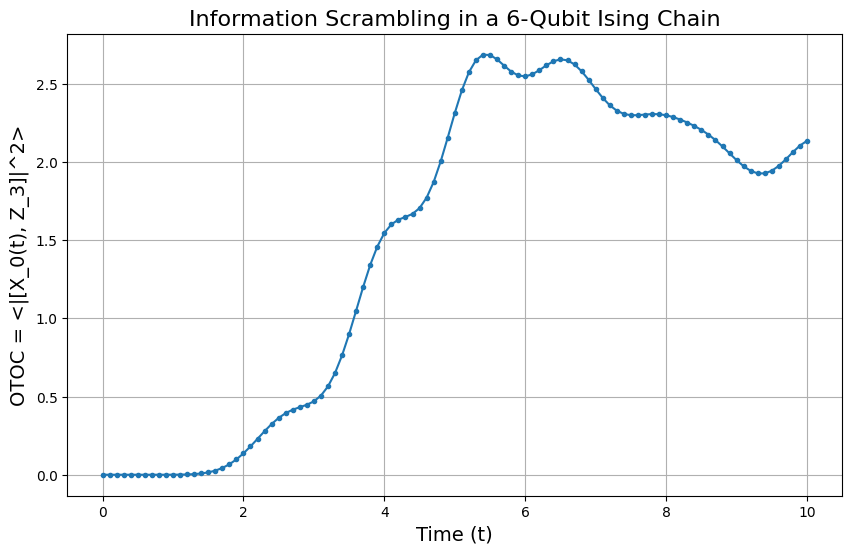

In [2]:
# Step 0: Install Cirq if you haven't already
# In Google Colab or Jupyter, run: !pip install cirq --quiet

import cirq
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

# --- 1. Define the Quantum System (Transverse-Field Ising Model) ---
# This model is a standard choice for studying many-body quantum dynamics.
# The Hamiltonian is: H = -J Σ Z_i Z_{i+1} - h Σ X_i
# J is the interaction strength, and h introduces quantum fluctuations and chaos.

# System Parameters
N = 6          # Number of qubits (spins). Keep this small (< 10) for this exact simulation method.
J = 1.0        # Coupling strength (interaction term)
h = 0.5        # Transverse field strength (chaos-inducing term)

# Define Pauli Matrices, which are the building blocks of our operators
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.identity(2)

def get_full_system_operator(op, i, num_qubits):
    """
    Creates the matrix for a single-qubit operator acting on qubit 'i' in a larger system.
    Uses tensor products (np.kron) to create the full-size matrix.

    Args:
        op (np.array): The single-qubit operator (e.g., X, Z).
        i (int): The index of the qubit the operator acts on.
        num_qubits (int): The total number of qubits in the system.

    Returns:
        np.array: A (2**num_qubits, 2**num_qubits) matrix for the operator.
    """
    op_list = [I] * num_qubits
    op_list[i] = op

    full_op = op_list[0]
    for k in range(1, num_qubits):
        full_op = np.kron(full_op, op_list[k])

    return full_op

# Construct the Hamiltonian Matrix for the entire system
dim = 2**N
Hamiltonian = np.zeros((dim, dim), dtype=complex)

# Add interaction terms: -J * Z_i * Z_{i+1}
for i in range(N - 1):
    z_i = get_full_system_operator(Z, i, N)
    z_j = get_full_system_operator(Z, i + 1, N)
    Hamiltonian -= J * (z_i @ z_j)

# Add transverse field terms: -h * X_i
for i in range(N):
    x_i = get_full_system_operator(X, i, N)
    Hamiltonian -= h * x_i

print(f"Hamiltonian for {N} qubits (shape: {Hamiltonian.shape}) created.")


# --- 2. Define OTOC Operators and Initial State ---
# The OTOC measures how a local operator W spreads out and fails to commute with another distant operator V.
# We will measure C(t) = -<[W(t), V]^2>, where W(t) = U(t)† W U(t) is the time-evolved operator.

# Choose a simple local operator W (e.g., Pauli-X on the first qubit)
W = get_full_system_operator(X, 0, N)

# Choose a second local operator V at a different site (e.g., Pauli-Z in the middle)
m = N // 2
V = get_full_system_operator(Z, m, N)

# Use a simple initial state: all qubits in the |0> state, i.e., |00...0>
initial_state_ket = np.zeros(dim)
initial_state_ket[0] = 1
initial_state_ket = initial_state_ket.reshape(dim, 1) # Make it a column vector
initial_state_bra = initial_state_ket.conj().T        # Corresponding row vector


# --- 3. Simulate the Time Evolution and Calculate the OTOC ---
# We will loop through time, evolve the operator W(t), and compute the OTOC value.

time_steps = np.linspace(0, 10, 101) # An array of time points to calculate the OTOC for
otoc_values = []

print("Simulating OTOC evolution...")
for t in time_steps:
    # Calculate the time evolution operator U(t) = exp(-iHt) using matrix exponentiation.
    # This is an exact but computationally expensive method.
    U_t = expm(-1j * Hamiltonian * t)
    U_t_dagger = U_t.conj().T

    # Calculate the Heisenberg picture operator W(t) = U†(t) W U(t)
    W_t = U_t_dagger @ W @ U_t

    # Calculate the commutator: [W(t), V] = W(t)V - VW(t)
    commutator = (W_t @ V) - (V @ W_t)

    # We measure the OTOC as the expectation value of the squared commutator's norm.
    # C(t) = -<Ψ| [W(t), V]† [W(t), V] |Ψ>
    commutator_squared_norm = commutator.conj().T @ commutator

    expectation_value = (initial_state_bra @ commutator_squared_norm @ initial_state_ket)[0, 0]
    otoc_values.append(np.real(expectation_value))

print("Simulation complete!")


# --- 4. Plot the Results ---
plt.figure(figsize=(10, 6))
plt.plot(time_steps, otoc_values, marker='.', linestyle='-')
plt.xlabel("Time (t)", fontsize=14)
plt.ylabel(f"OTOC = <|[X_0(t), Z_{m}]|^2>", fontsize=14)
plt.title(f"Information Scrambling in a {N}-Qubit Ising Chain", fontsize=16)
plt.grid(True)
plt.show()